In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'PAAS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,192,-173,19,-293,250,24,284,872,7,...,2768,52,20,4,154,34,585,46,-34,152
1,2014-03-31,210,-178,32,7,178,136,276,838,7,...,2731,55,15,5,124,35,561,36,-37,152
2,2014-06-30,201,-191,10,-6,179,136,263,831,7,...,2729,54,3,5,150,36,583,49,-37,152
3,2014-09-30,178,-191,-12,-20,160,105,251,782,7,...,2673,46,14,4,146,34,565,39,-28,152
4,2014-12-31,163,-185,-21,-526,146,64,253,731,3,...,2018,53,18,39,174,0,455,1,-30,152


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,210,375,-340,35,-172,107,137,472,...,0,3248,89,0,27,381,180,1053,-112,-72
37,2023-03-31,2023-04-21,365,390,-313,77,16,411,173,676,...,0,9113,203,0,72,508,1058,4115,51,-39
38,2023-06-30,2023-07-21,365,640,-569,71,-47,368,156,682,...,0,8962,203,0,64,532,1014,4052,117,-113
39,2023-09-30,2023-10-21,365,616,-554,62,-23,348,150,701,...,0,7534,191,0,54,516,705,2686,115,-109
40,2023-12-31,2024-02-11,365,670,-605,65,-68,400,138,712,...,0,7213,498,0,32,624,697,2441,167,-169


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,210,375,-340,35,-172,107,137,472,...,3248,89,0,27,381,180,1053,-112,-72,1.357405
37,2023-03-31,2023-04-21,365,390,-313,77,16,411,173,676,...,9113,203,0,72,508,1058,4115,51,-39,1.352063
38,2023-06-30,2023-07-21,365,640,-569,71,-47,368,156,682,...,8962,203,0,64,532,1014,4052,117,-113,1.343352
39,2023-09-30,2023-10-21,365,616,-554,62,-23,348,150,701,...,7534,191,0,54,516,705,2686,115,-109,1.341033
40,2023-12-31,2024-02-11,365,670,-605,65,-68,400,138,712,...,7213,498,0,32,624,697,2441,167,-169,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,210,509.026907,-461.517729,47.509178,-233.473675,145.242344,185.964497,640.695200,...,4408.851716,120.809053,0.0,36.649937,517.171337,244.332915,1429.347554,-152.029370,-97.733166,1.357405
37,2023-03-31,2023-04-21,365,527.304436,-423.195611,104.108824,21.633002,555.697751,233.906839,913.994355,...,12321.346981,274.468719,0.0,97.348511,686.847829,1430.482290,5563.737828,68.955195,-52.730444,1.352063
38,2023-06-30,2023-07-21,365,859.745103,-764.367131,95.377972,-63.137531,494.353434,209.562869,916.165876,...,12039.118147,272.700400,0.0,85.974510,714.663117,1362.158648,5443.261184,157.172152,-151.798745,1.343352
39,2023-09-30,2023-10-21,365,826.076281,-742.932239,83.144041,-30.843757,466.679457,201.154938,940.064079,...,10103.342043,256.137288,0.0,72.415778,691.972988,945.428211,3602.014432,154.218786,-146.172589,1.341033
40,2023-12-31,2024-02-11,365,912.283651,-823.778520,88.505130,-92.589982,544.646956,187.903200,969.471581,...,9821.346228,678.085460,0.0,43.571756,849.649251,949.047320,3323.708047,227.390104,-230.113339,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,14.339797,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,0.788656,0.211344,32.0,13.307692,3.072,2.43662,0.098958,-1.526042,-0.42341,-0.536876
1,2014-02-24,13.300924,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,0.788656,0.211344,32.0,13.307692,3.072,2.43662,0.098958,-1.526042,-0.42341,-0.536876
2,2014-03-03,13.589067,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,0.788656,0.211344,32.0,13.307692,3.072,2.43662,0.098958,-1.526042,-0.42341,-0.536876
3,2014-03-10,14.173172,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,0.788656,0.211344,32.0,13.307692,3.072,2.43662,0.098958,-1.526042,-0.42341,-0.536876
4,2014-03-17,13.408680,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,0.788656,0.211344,32.0,13.307692,3.072,2.43662,0.098958,-1.526042,-0.42341,-0.536876


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,14.339797,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,2.43662,0.098958,-1.526042,-0.42341,-0.536876,-1.772238,0.951472,2.704509,3.140707,6.490821
1,2014-02-24,13.300924,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,2.43662,0.098958,-1.526042,-0.42341,-0.536876,-1.643845,0.882541,2.508576,2.944774,6.020582
2,2014-03-03,13.589067,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,2.43662,0.098958,-1.526042,-0.42341,-0.536876,-1.679456,0.901659,2.562920,2.999118,6.151007
3,2014-03-10,14.173172,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,2.43662,0.098958,-1.526042,-0.42341,-0.536876,-1.751645,0.940416,2.673083,3.109281,6.415399
4,2014-03-17,13.408680,2013-12-31,201.482911,-8.09135,15.071176,152.0,335.804852,2.209242,262.347541,...,2.43662,0.098958,-1.526042,-0.42341,-0.536876,-1.657162,0.889690,2.528899,2.965096,6.069356


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

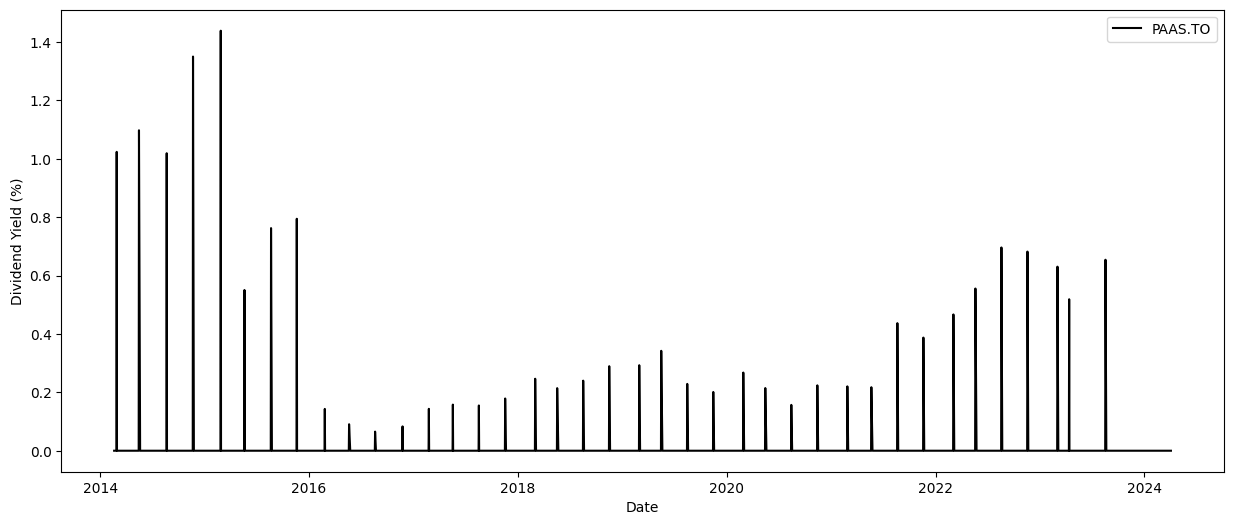

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.17178
share_price      1.00000
Name: share_price, dtype: float64


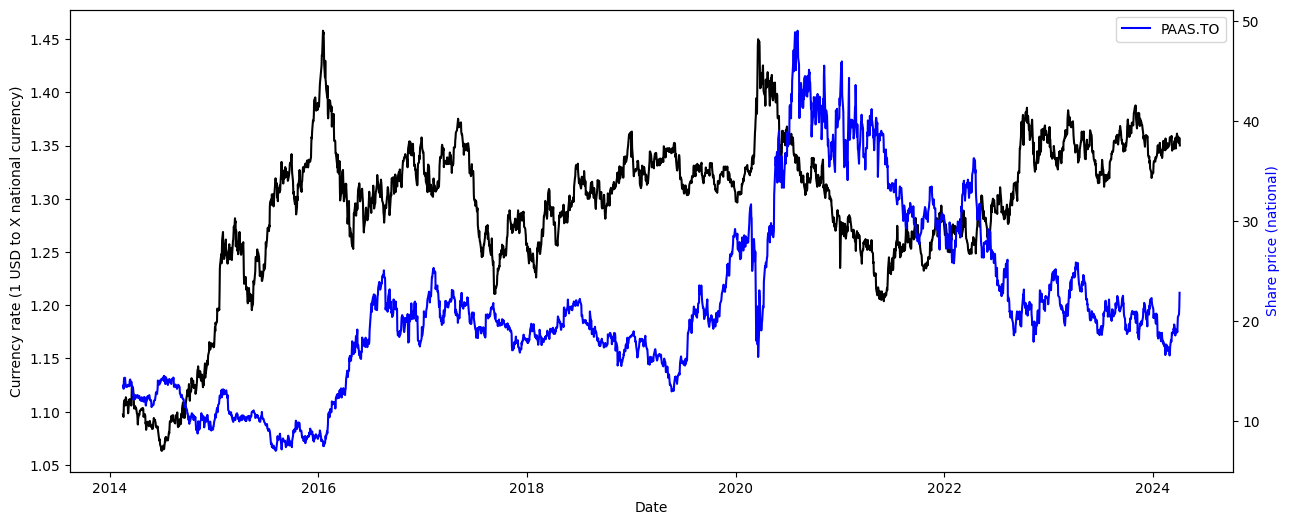

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

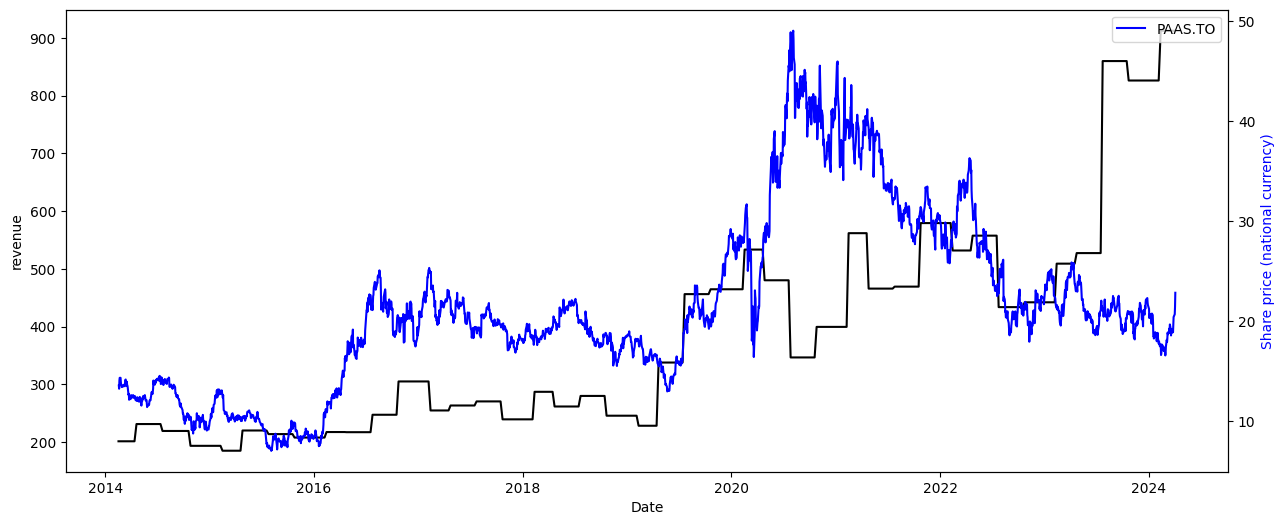

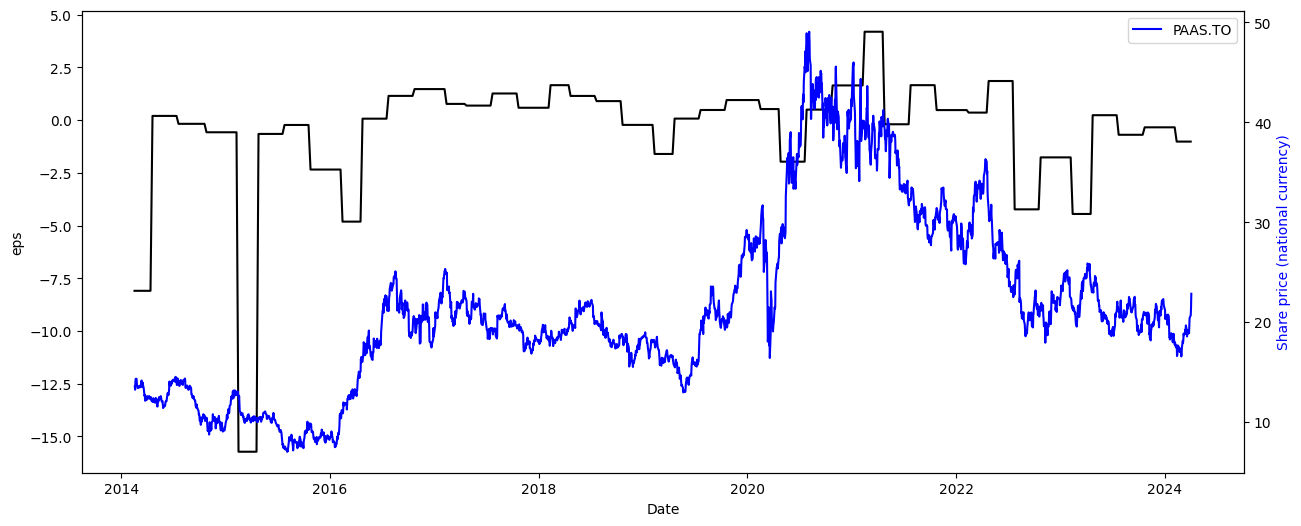

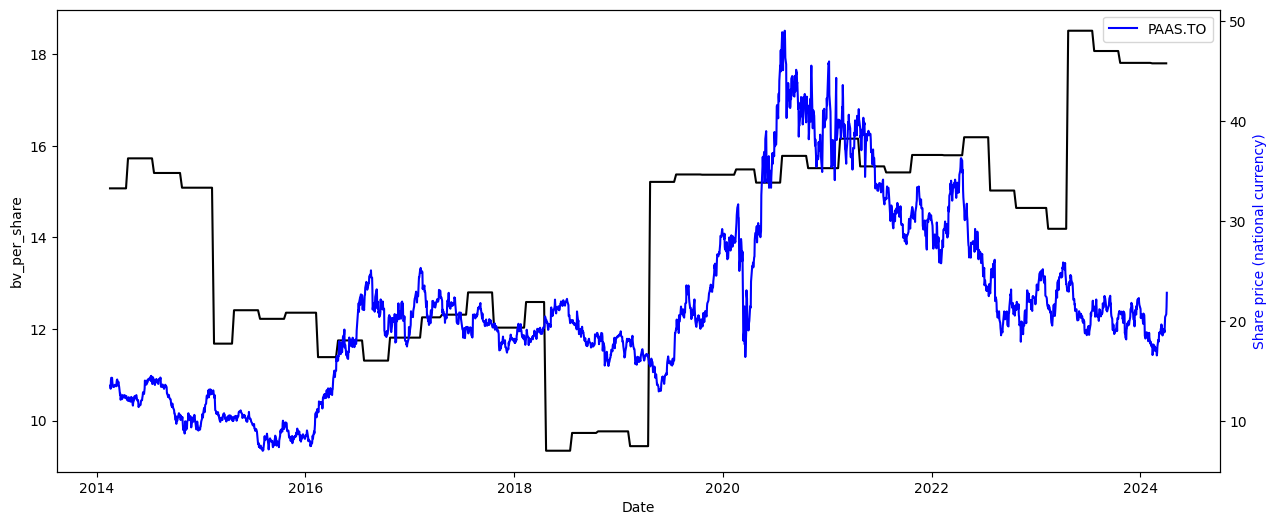

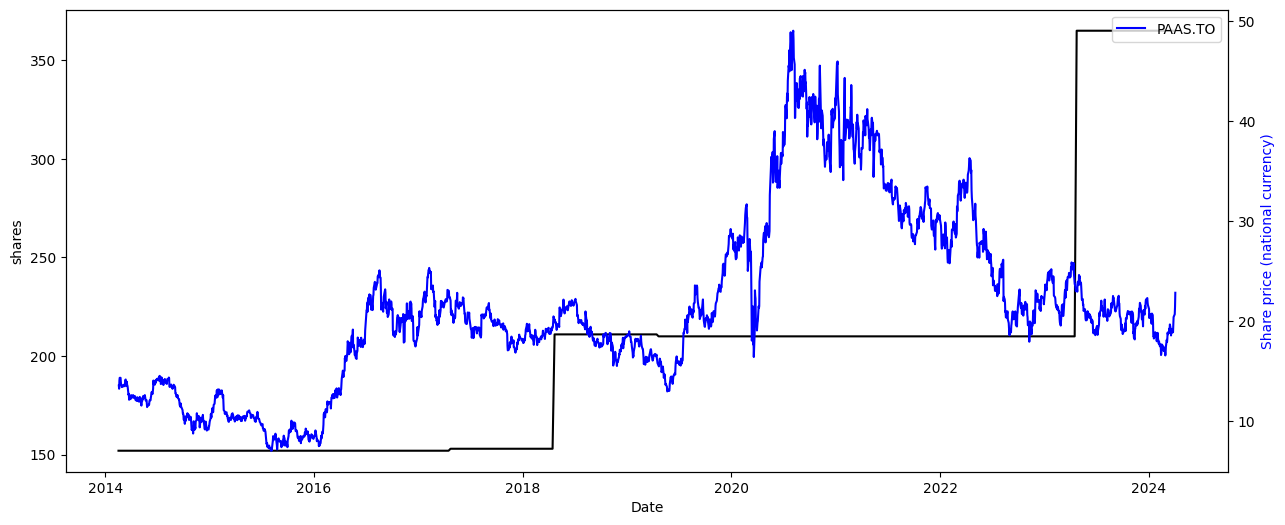

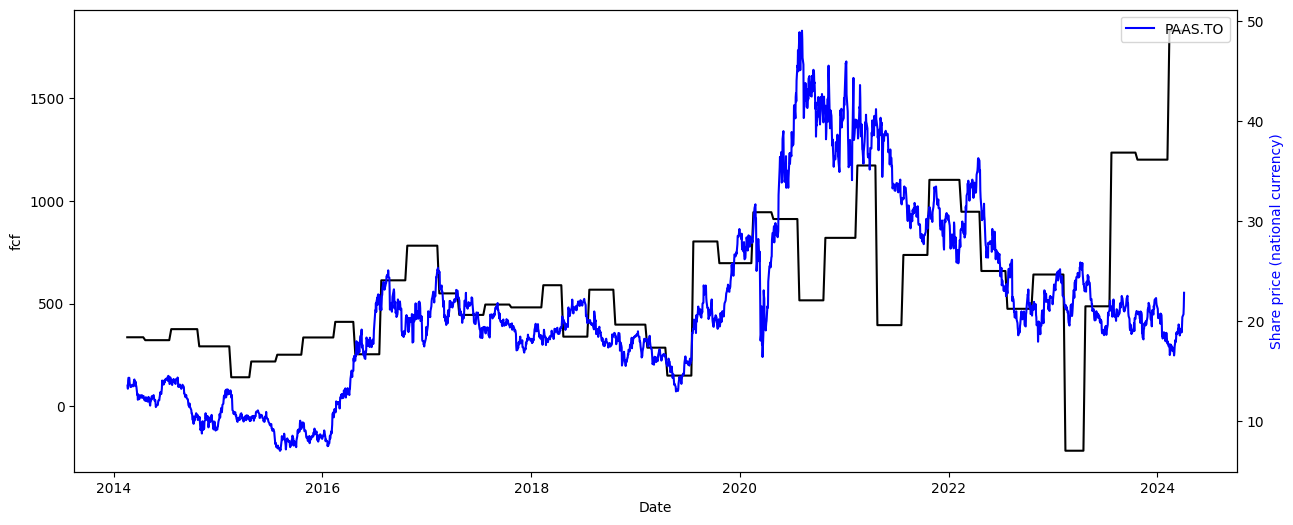

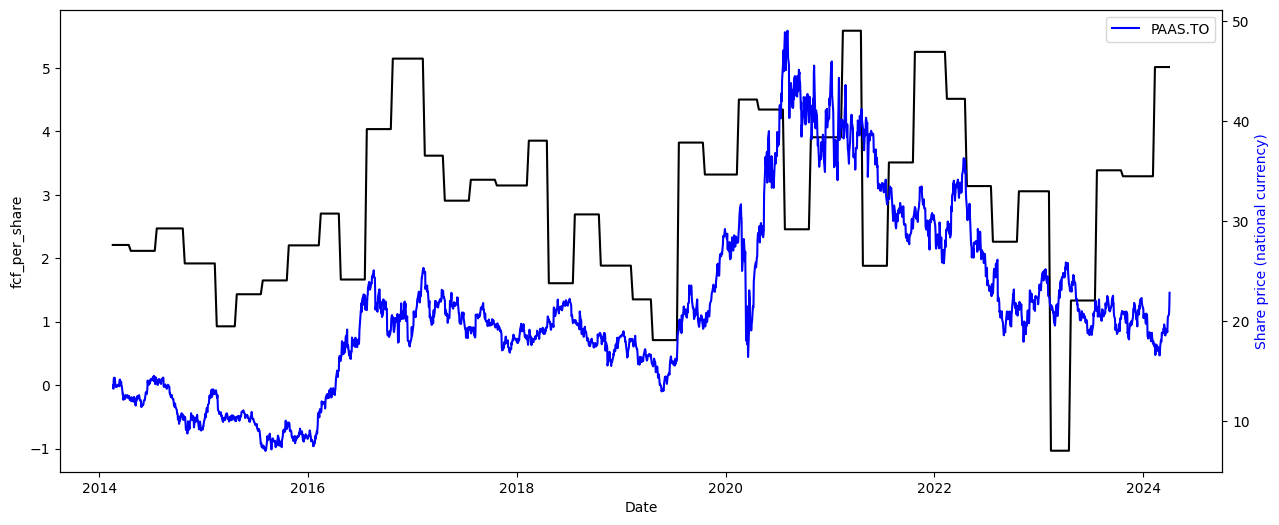

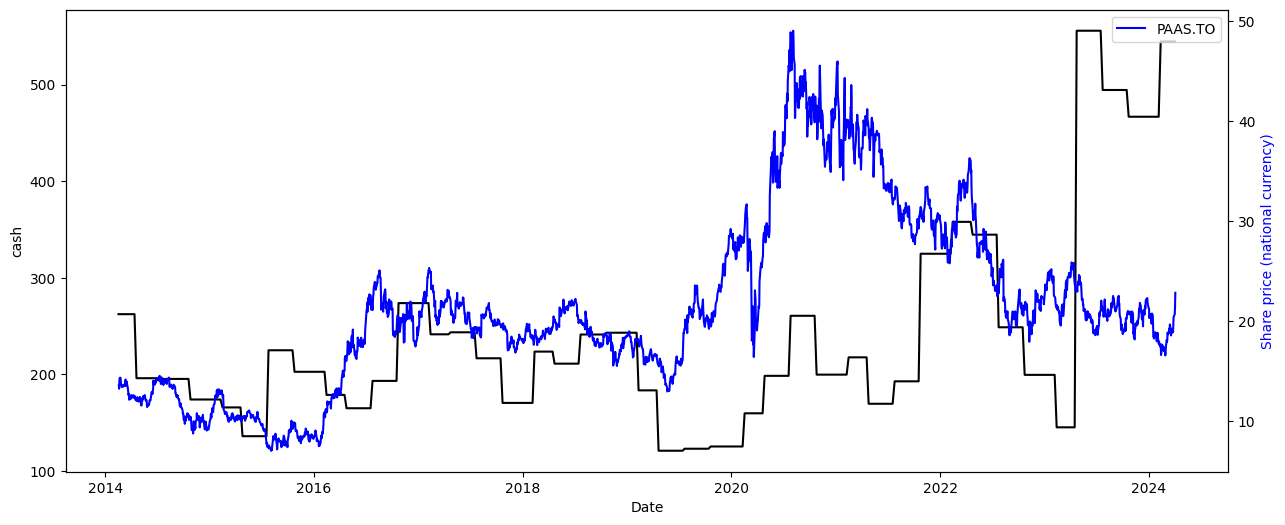

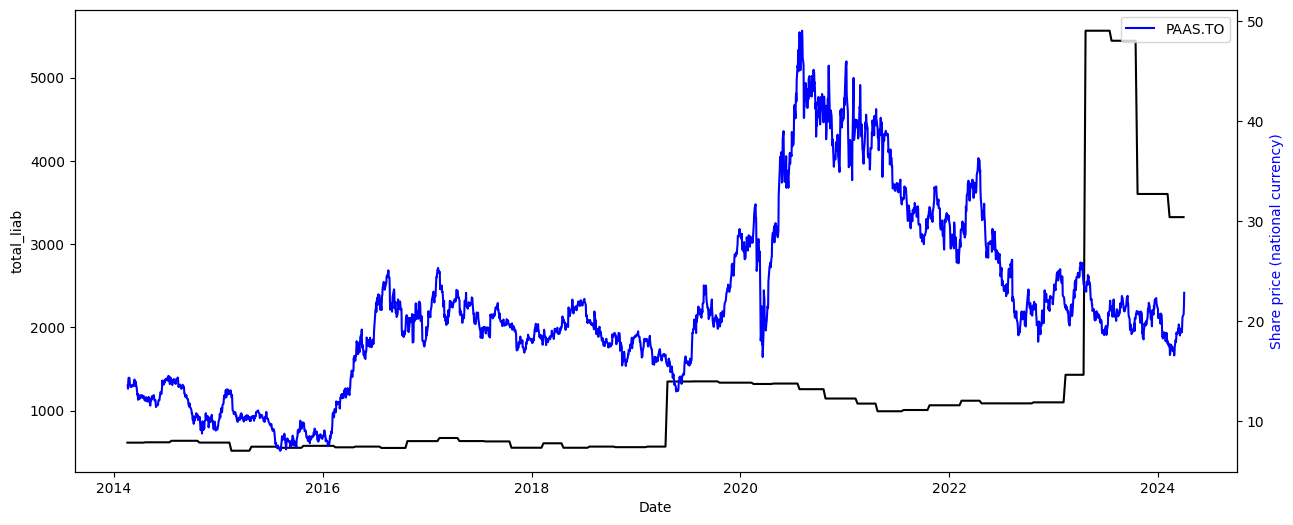

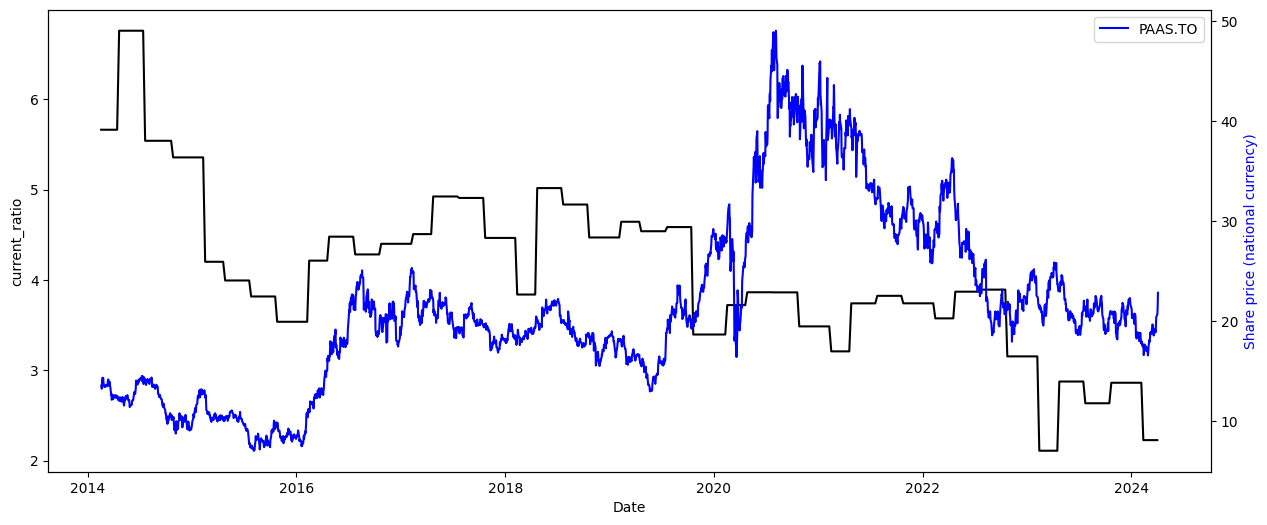

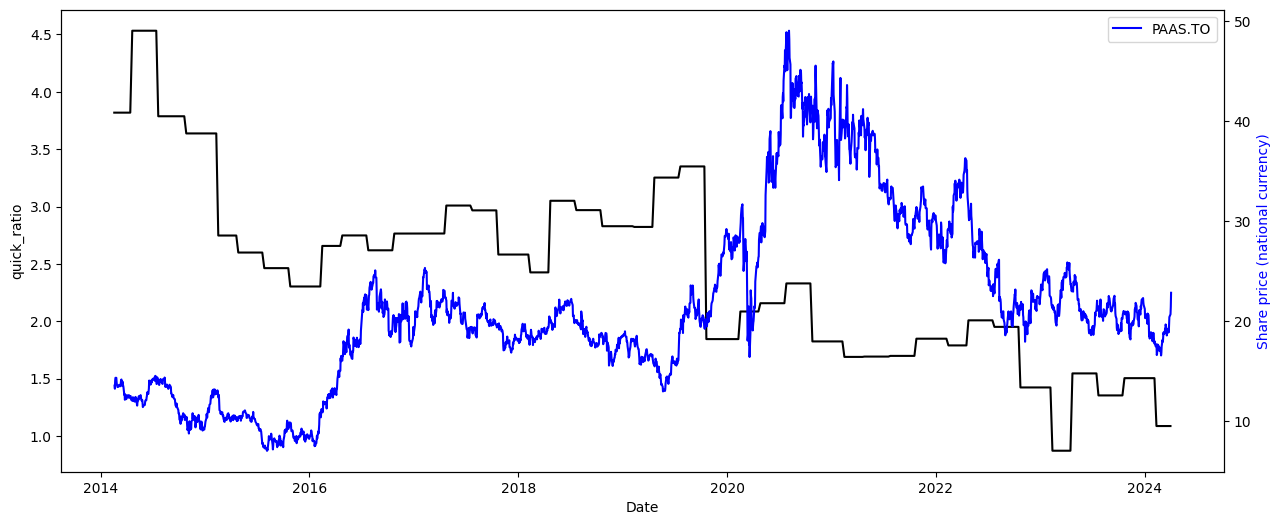

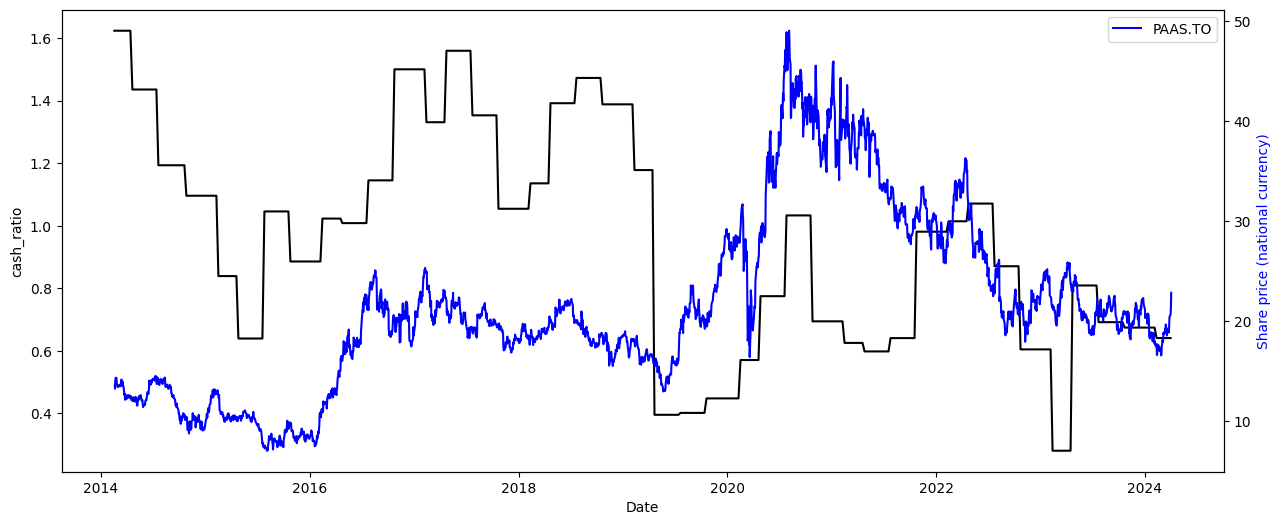

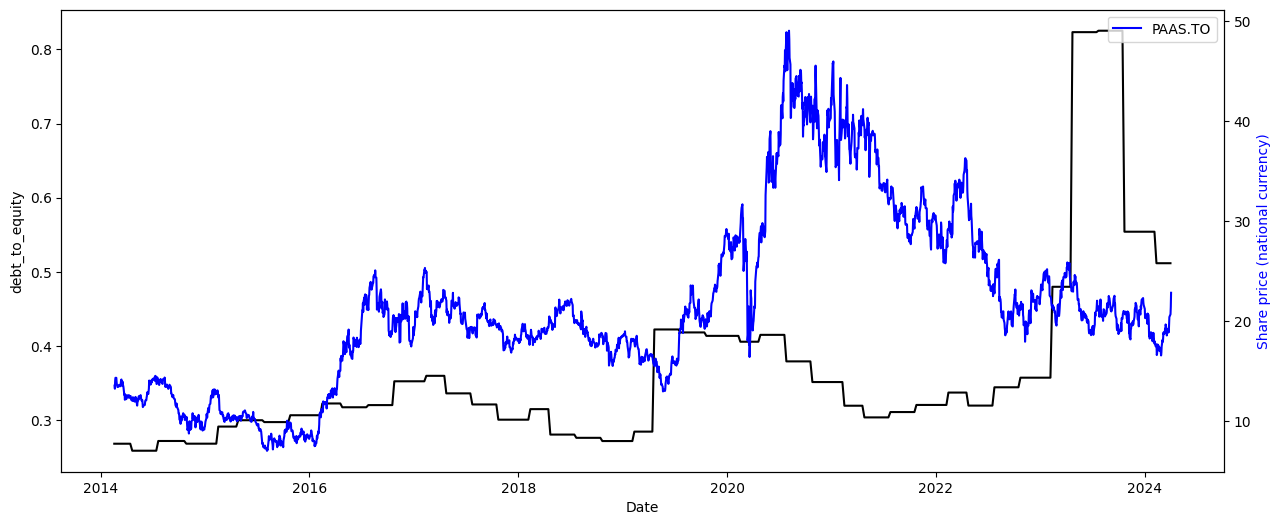

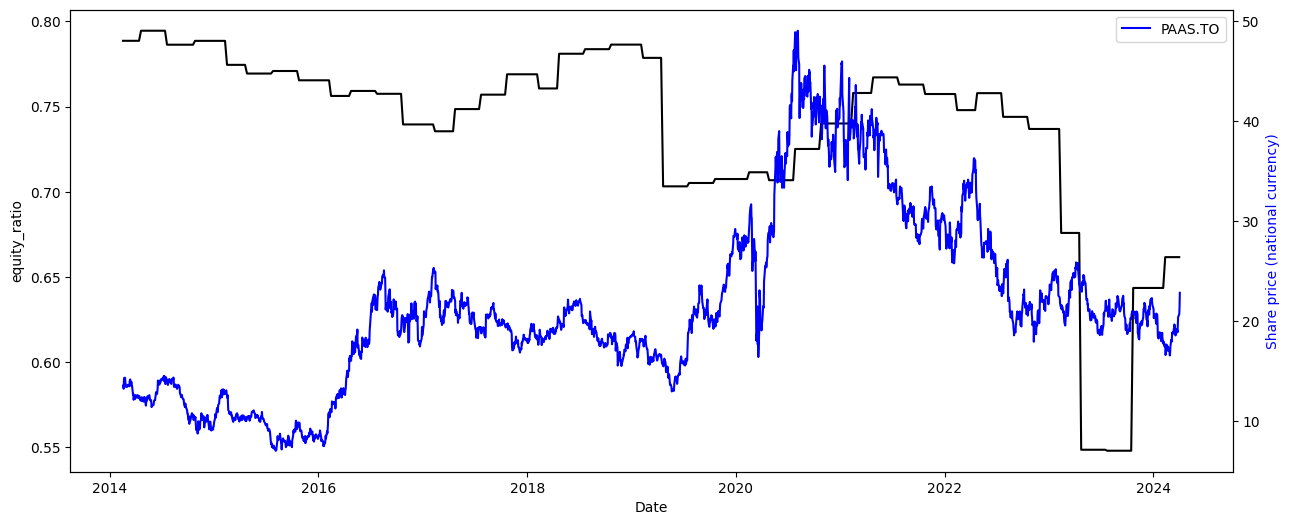

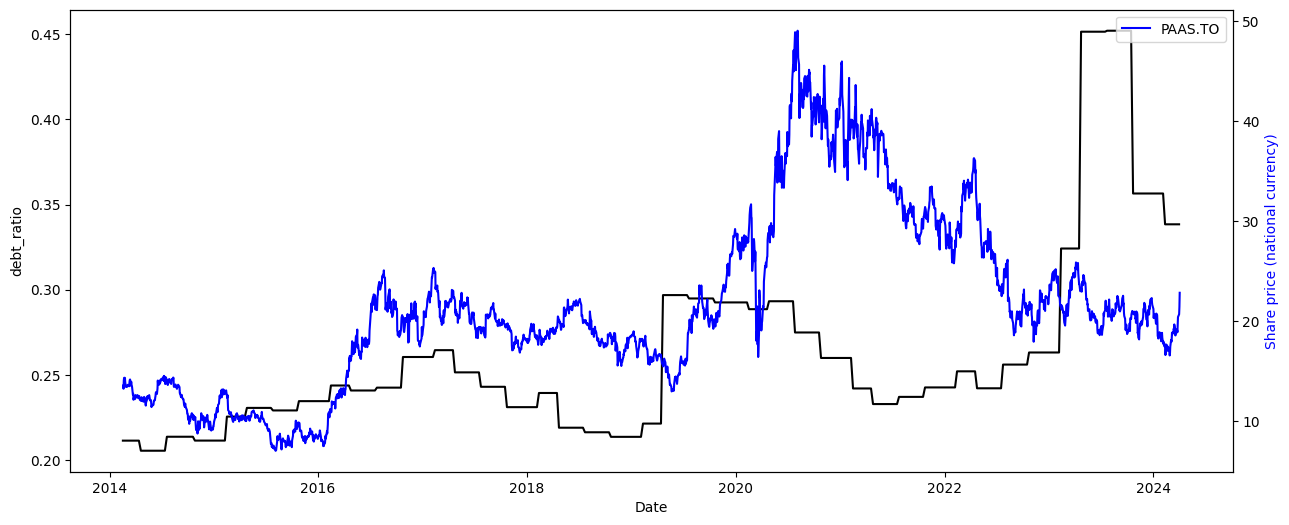

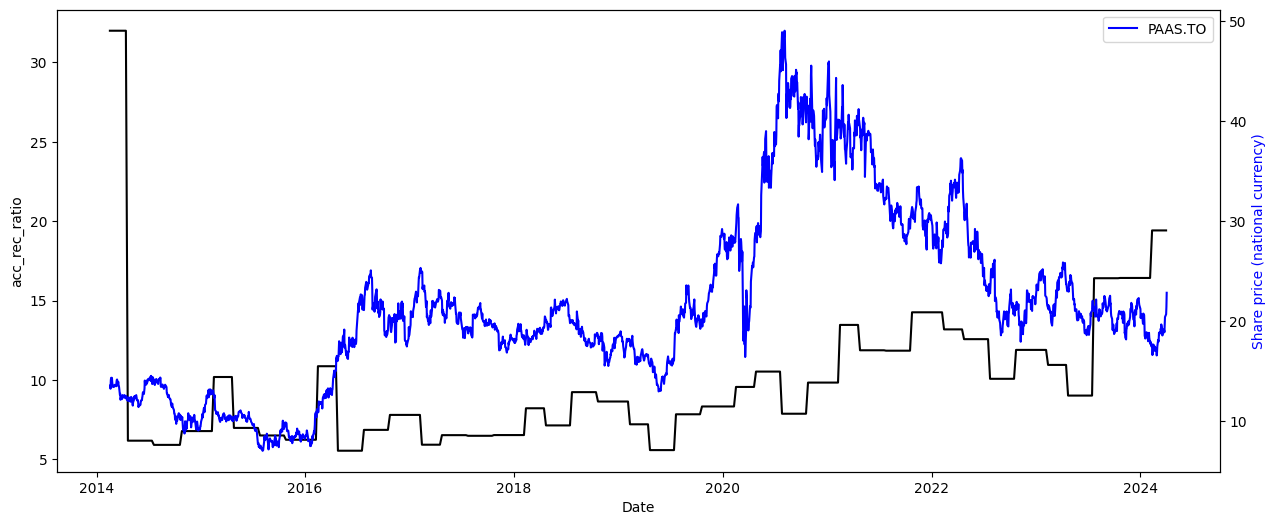

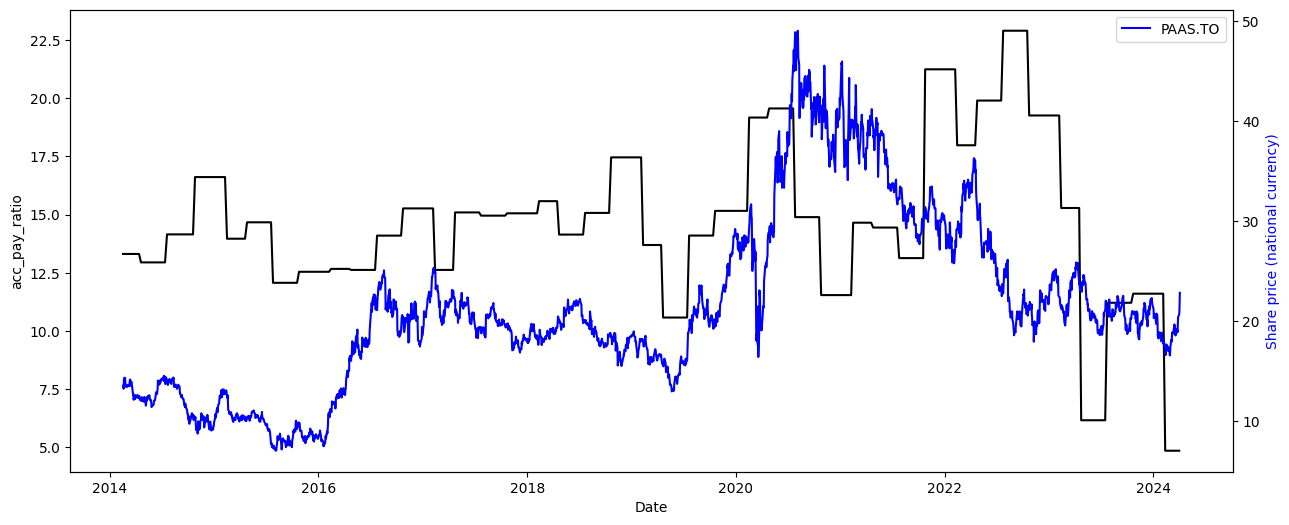

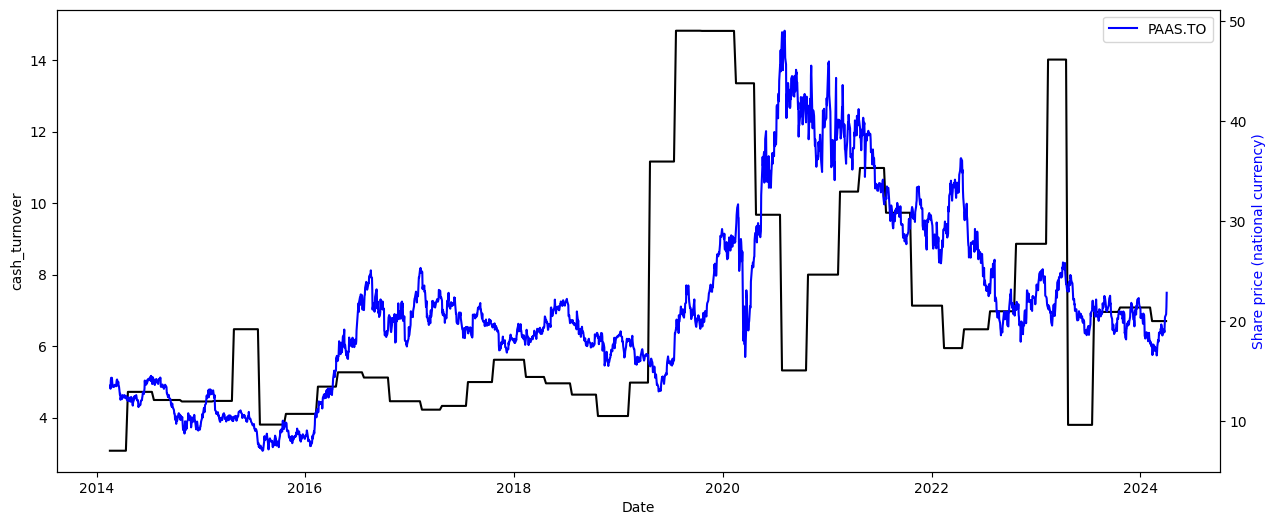

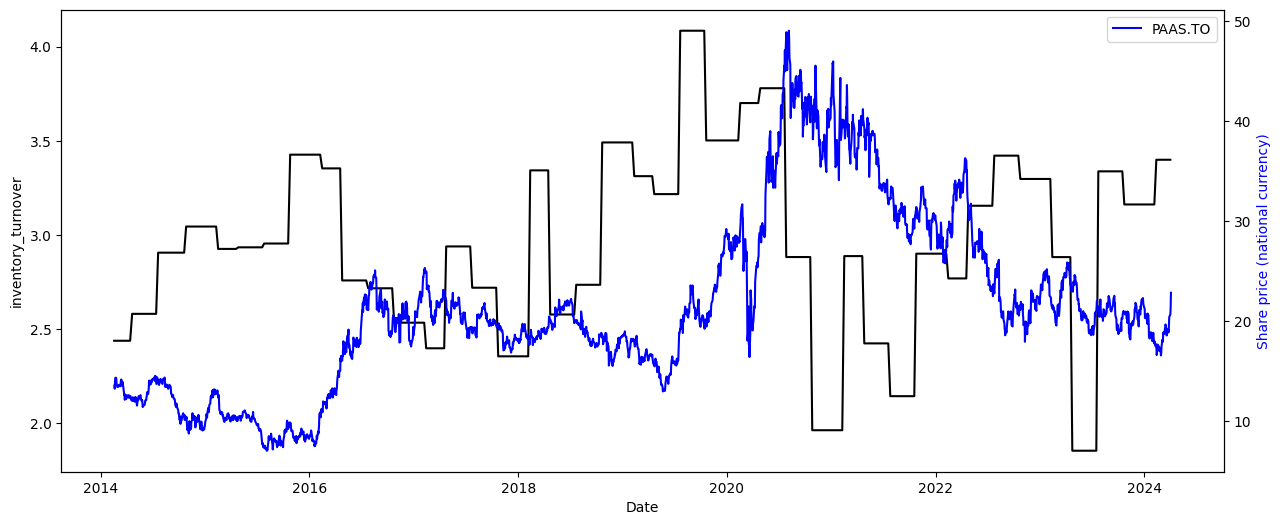

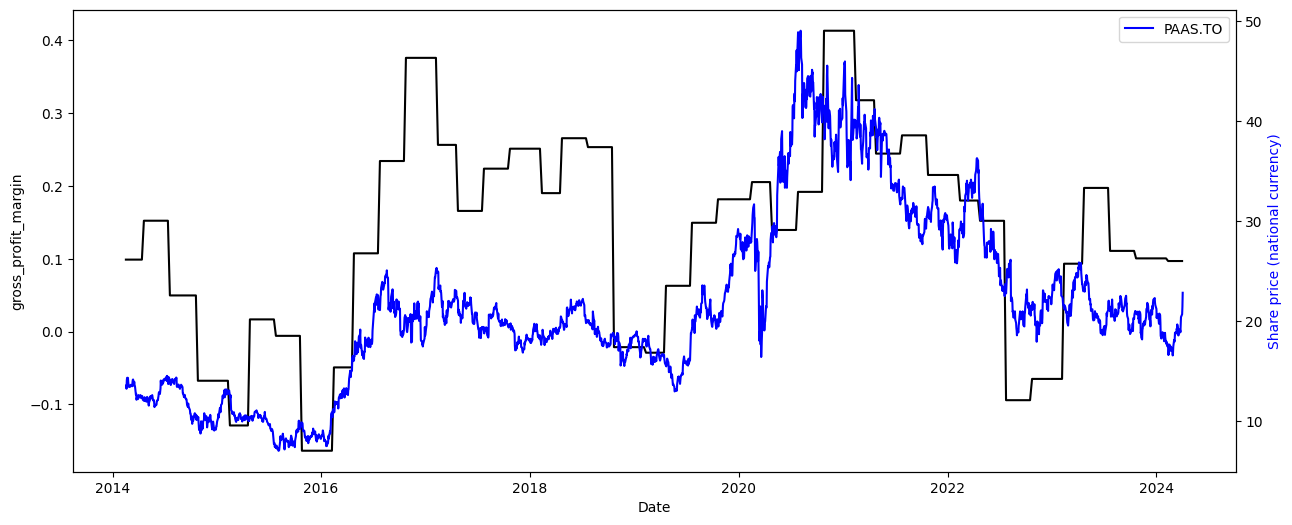

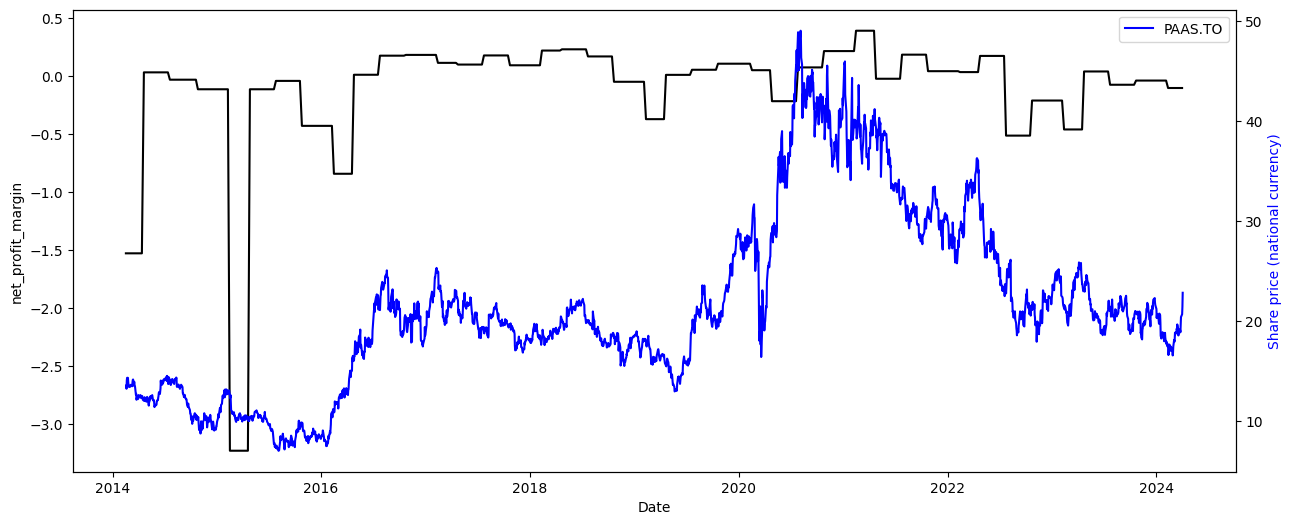

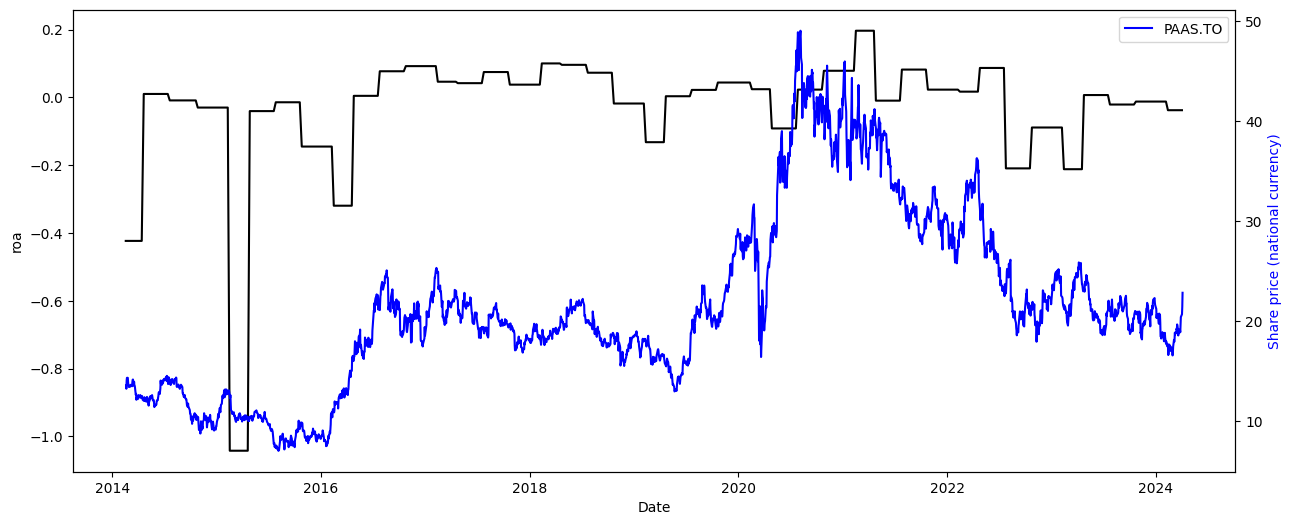

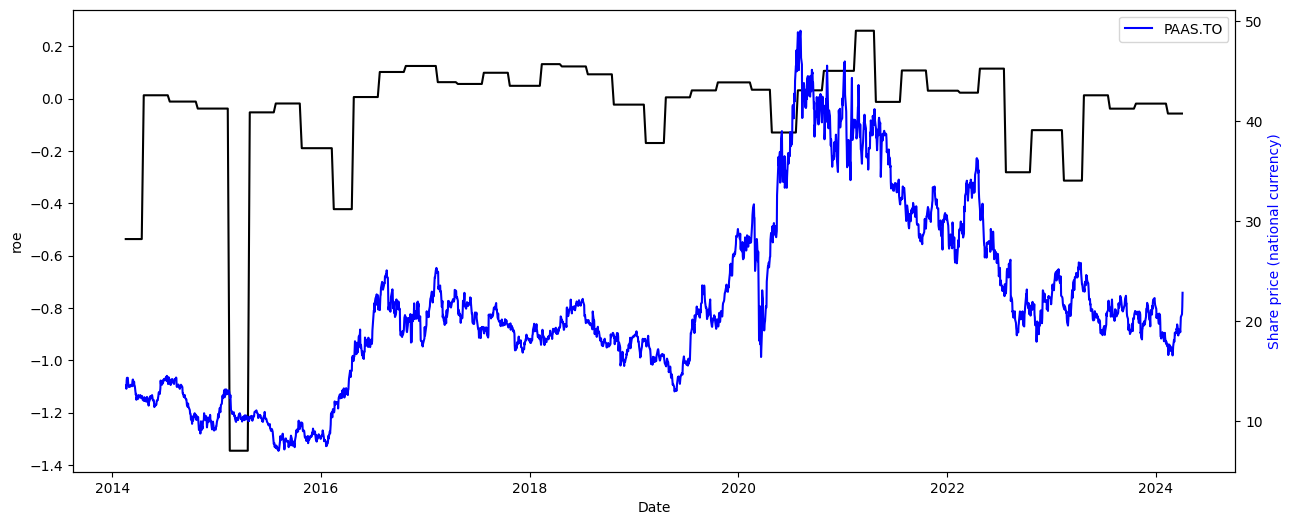

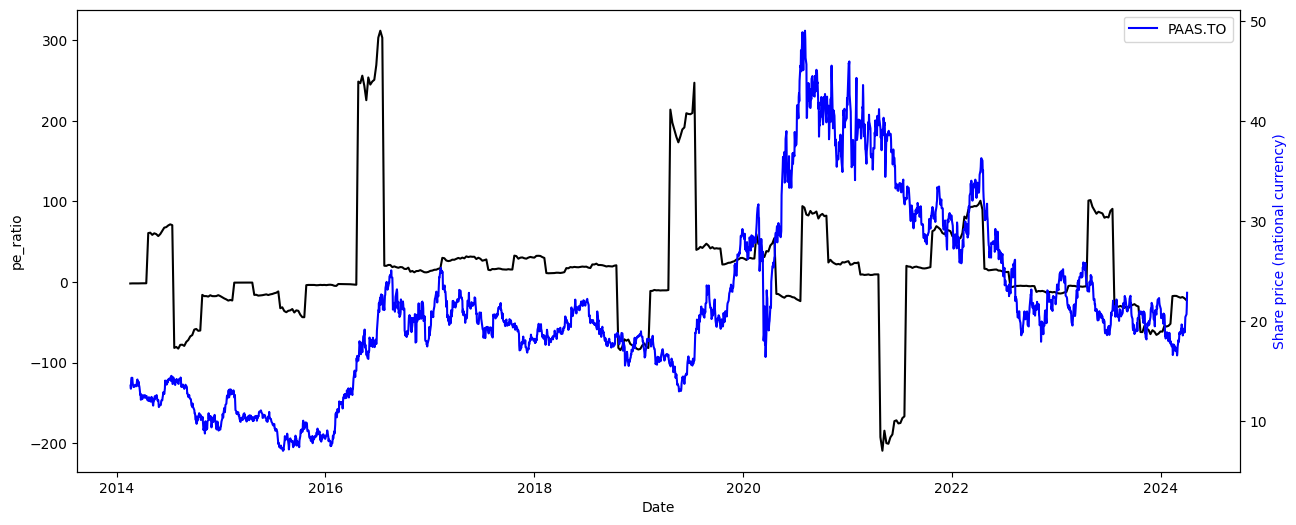

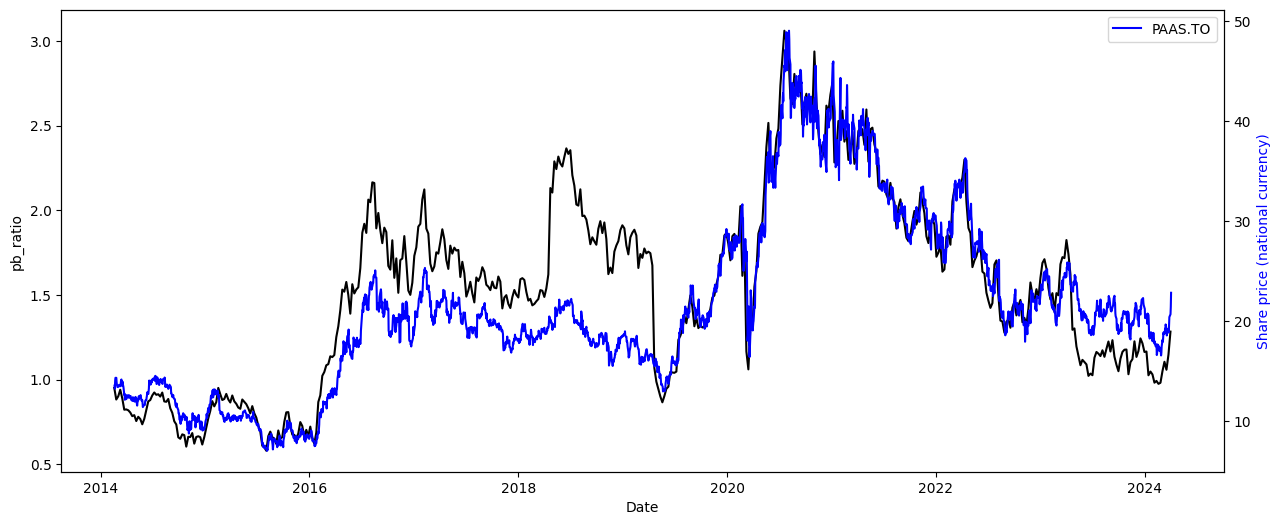

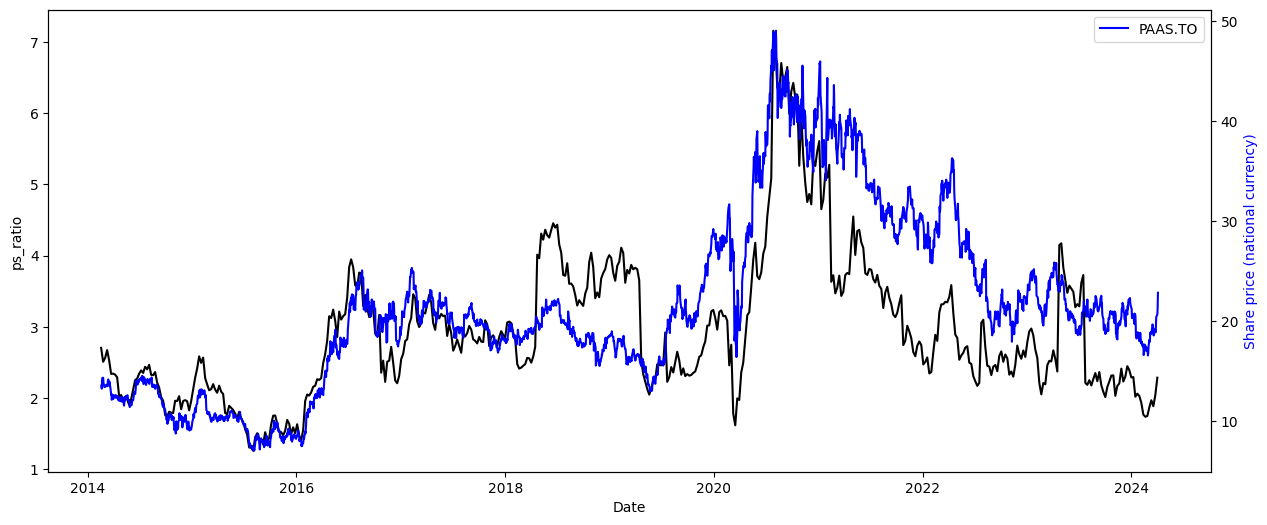

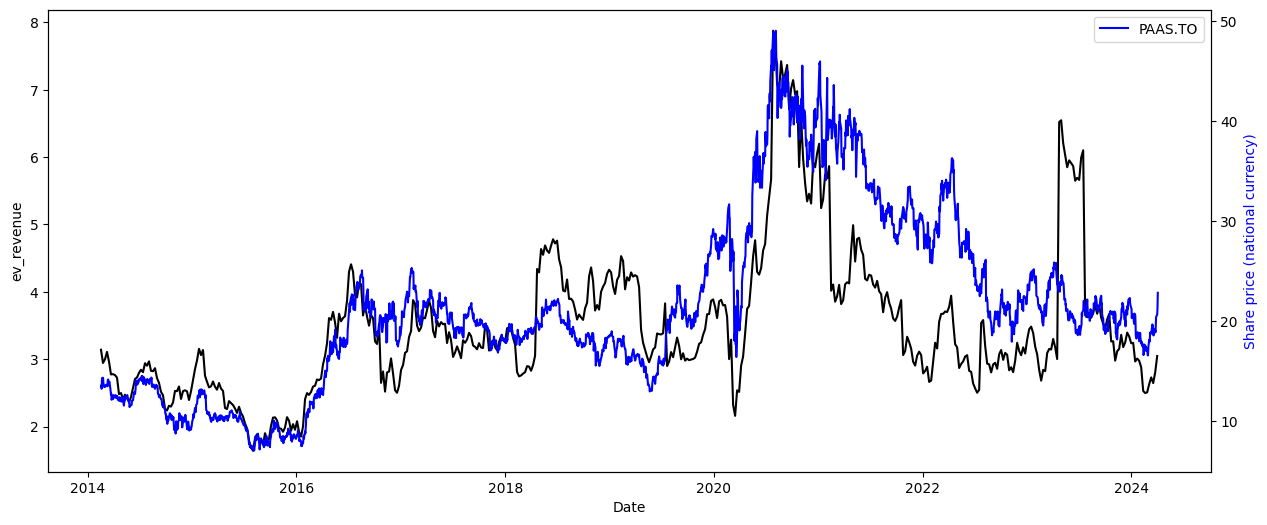

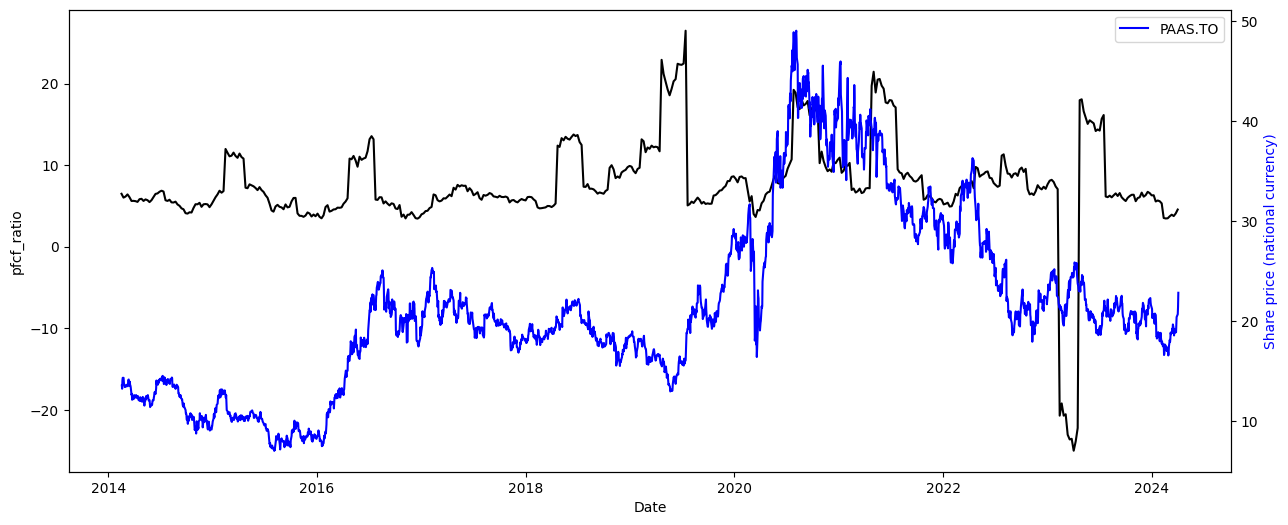

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

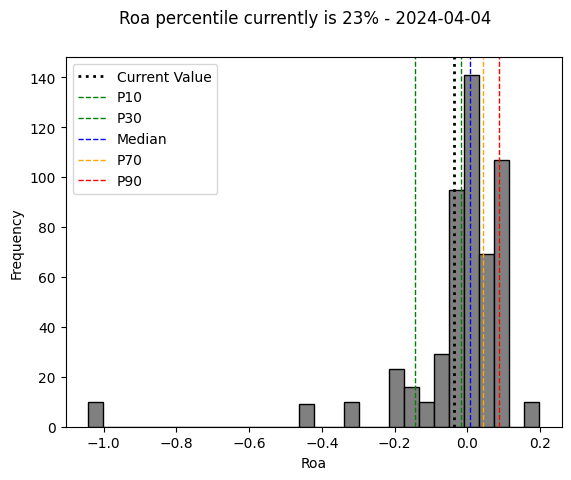

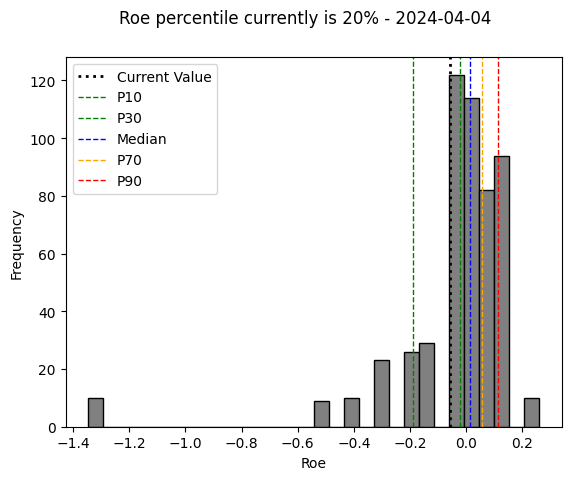

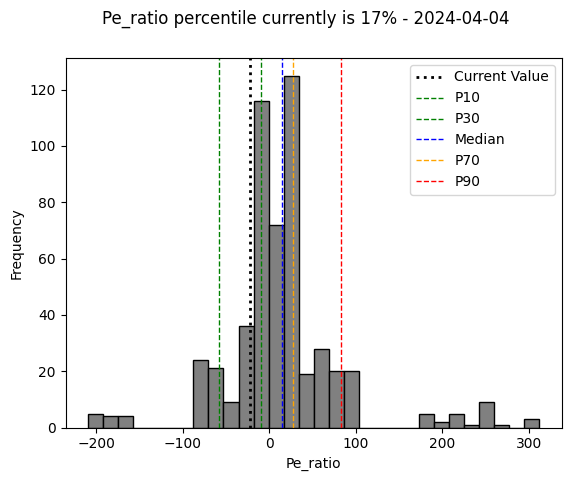

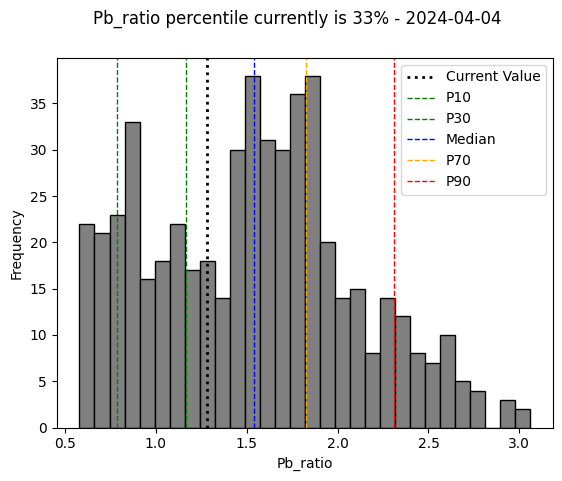

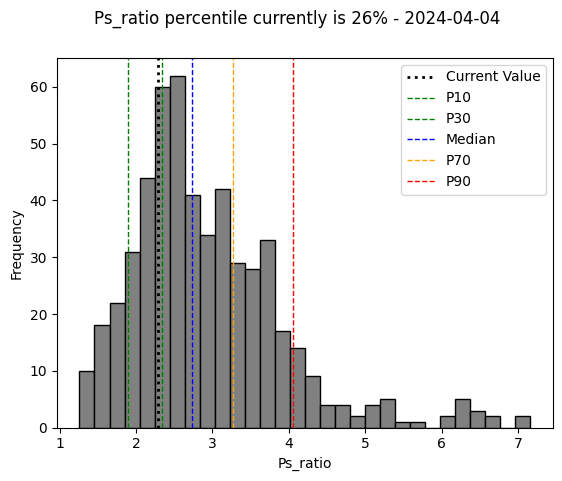

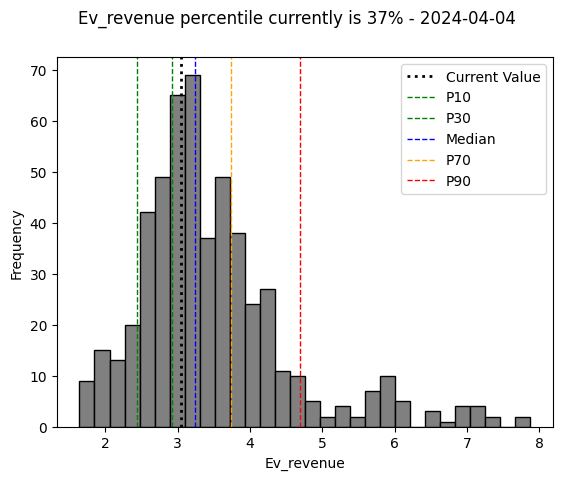

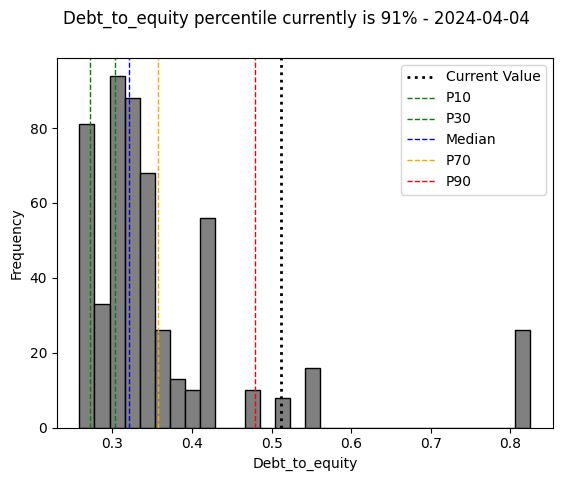

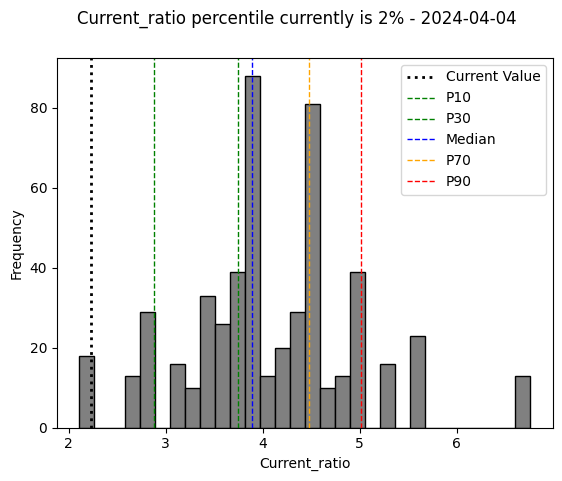

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.999557,0.127704,0.359133,0.251234,0.230988,0.056154,0.001922
roe,0.999557,1.000000,0.131730,0.358354,0.254628,0.233145,0.047584,0.014294
pe_ratio,0.127704,0.131730,1.000000,0.046228,0.116857,0.157515,0.078349,0.121579
pb_ratio,0.359133,0.358354,0.046228,1.000000,0.864917,0.734800,-0.098151,-0.179398
ps_ratio,0.251234,0.254628,0.116857,0.864917,1.000000,0.942600,-0.022728,-0.039217
ev_revenue,0.230988,0.233145,0.157515,0.734800,0.942600,1.000000,0.279730,-0.174407
debt_to_equity,0.056154,0.047584,0.078349,-0.098151,-0.022728,0.279730,1.000000,-0.608754
current_ratio,0.001922,0.014294,0.121579,-0.179398,-0.039217,-0.174407,-0.608754,1.000000


0 timestemos have been found!


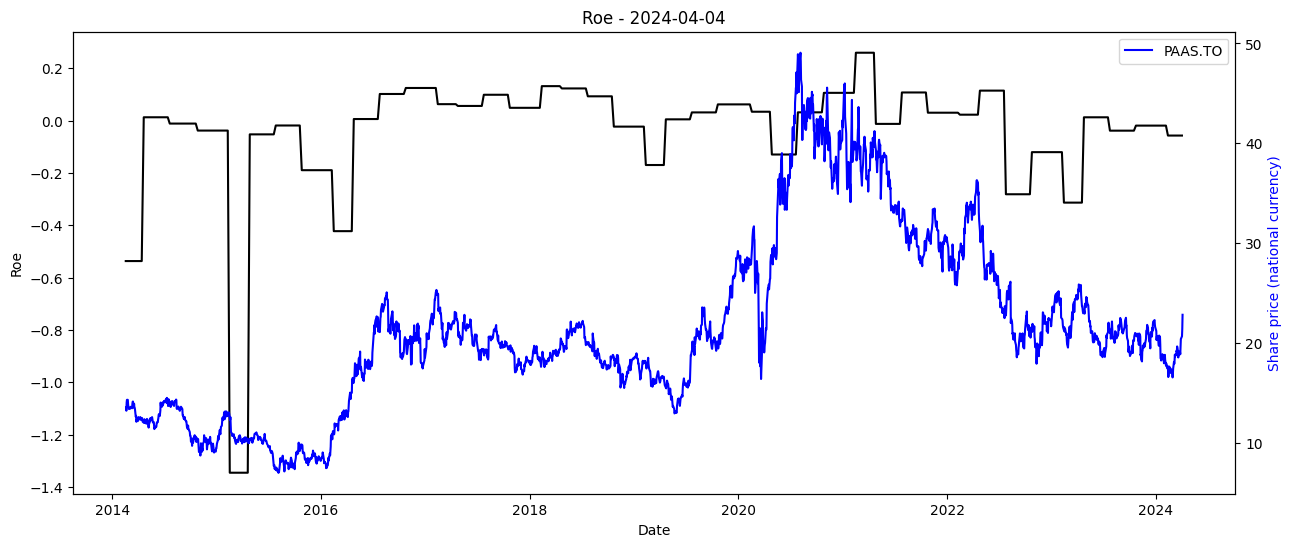

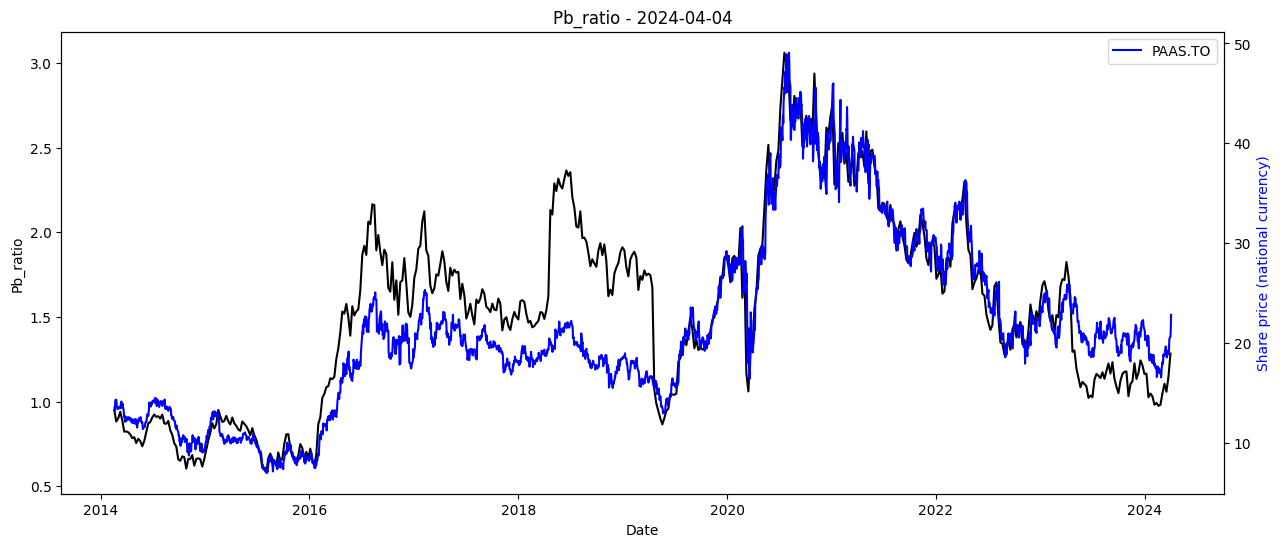

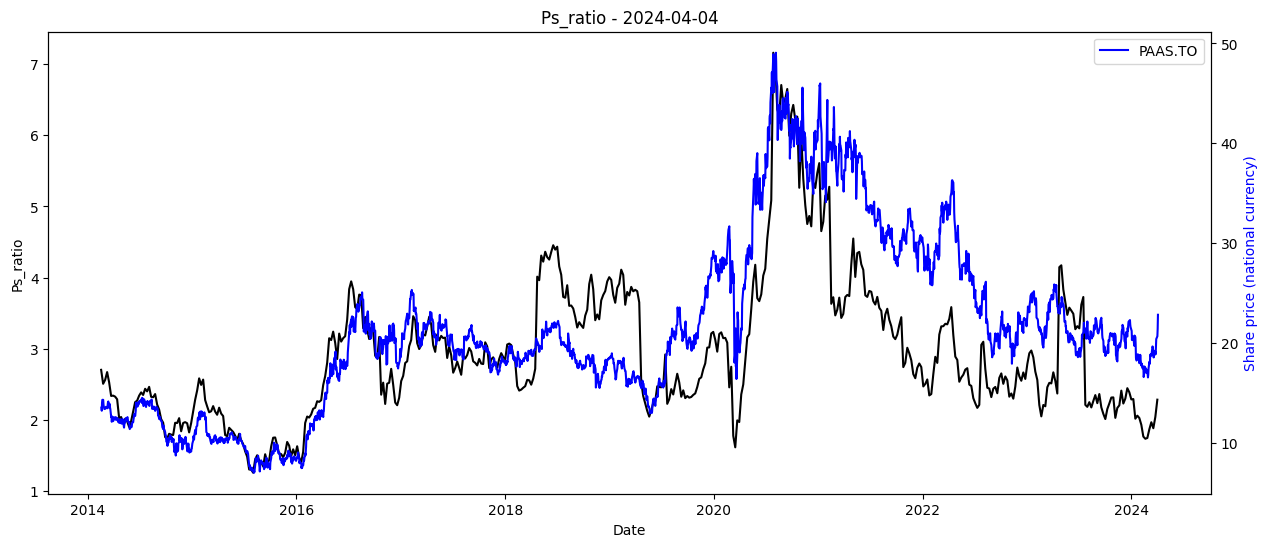

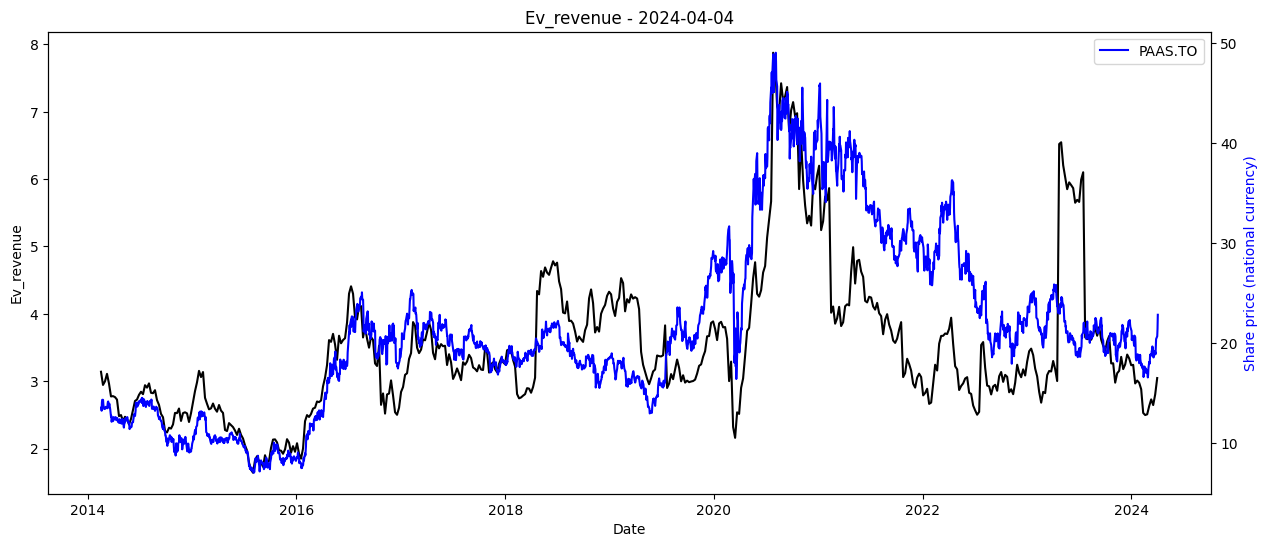

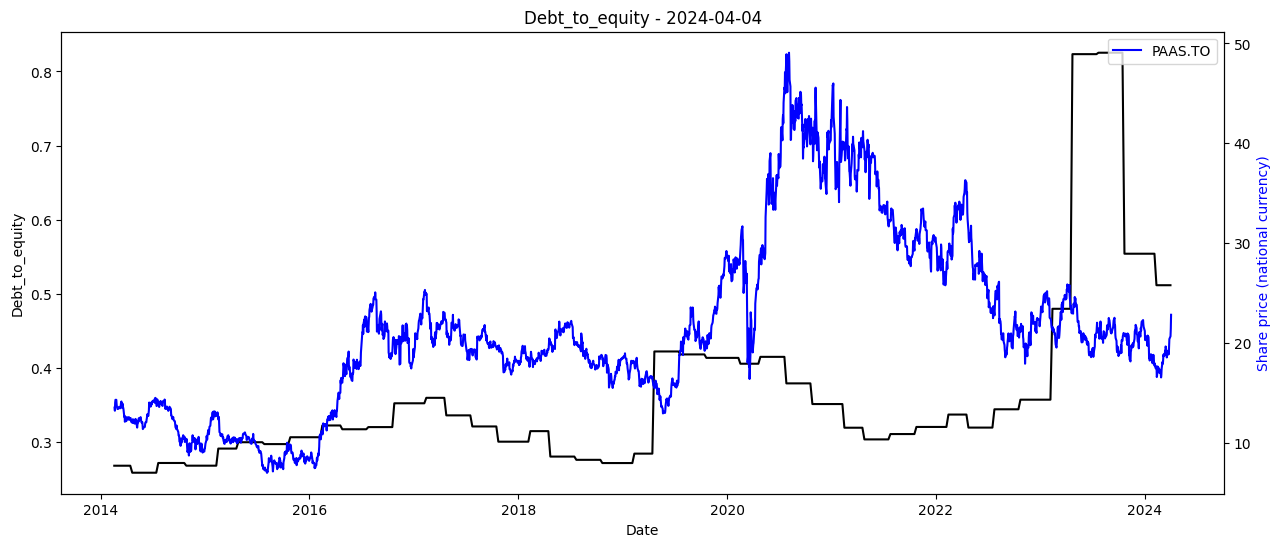

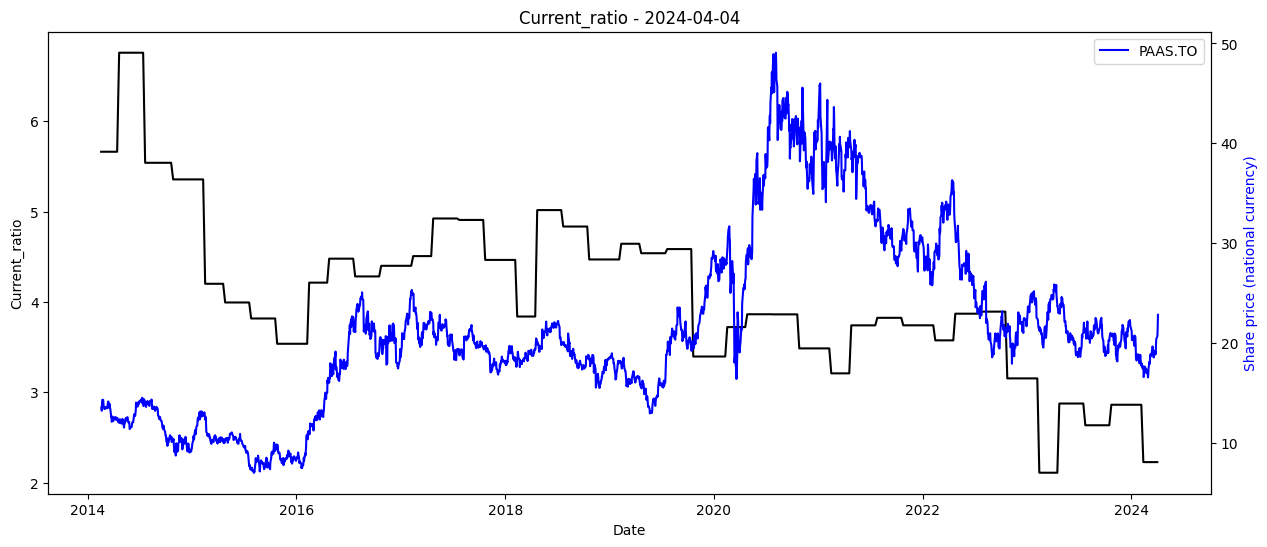

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )